# General Description

1. Create Datasets
2. Create AF jobs
3. analyze AF output

## 1. Create Datasets

- read in the human proteome (use reviewed proteins)
- filter for armadillo repeat proteins
- filter for Transcription Factor proteins
- Filter Transcription Factors for disordered Proteins
- STRING database matching

### Library imports and helper functions

In [ ]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def contains_any_annotation(cell_value, annotations_list):
    """check if any of the annotations are in the column value

    Args:
        cell_value (_type_): _description_
        annotations_list (_type_): _description_

    Returns:
        _type_: _description_
    """
    if pd.isna(cell_value):
        return False
    for annotation in annotations_list:
        if annotation in cell_value:
            return True
    return False

### Read in Proteome

In [37]:
all_proteins = pd.read_csv('data/Proteome/uniprotkb_proteome_UP000005640_2025_05_12.tsv', sep='\t')
reviewed_proteins = all_proteins[all_proteins['Reviewed'] == 'reviewed']

/tmp/ipykernel_25027/4255547013.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  all_proteins = pd.read_csv('data/Proteome/uniprotkb_proteome_UP000005640_2025_05_12.tsv', sep='\t')


### create Armadillo dataset

In [ ]:
# Filter for Armadillos
## all the interpro IDs that have the word "armadillo" in the description
arm_accs_ipr = [
    'IPR013636',
    'IPR024574',
    'IPR041322',
    'IPR055241',
    'IPR056252',
    'IPR016617',
    'IPR031524',
    'IPR038739',
    'IPR038905',
    'IPR039868',
    'IPR040268',
    'IPR042462',
    'IPR042834',
    'IPR043379',
    'IPR044282',
    'IPR051303',
    'IPR052441',
    'IPR011989',
    'IPR016024',
    'IPR000225',
    'IPR041209',
    'IPR049152',
    'IPR006911'
]

# all pfam accessions that have "armadillo" in the description
arm_accs_pfam = [
    'PF00514.29',
    'PF17822.6',
    'PF08427.15',
    'PF15767.10',
    'PF22915.1',
    'PF04826.19',
    'PF23295.1',
    'PF16629.10',
    'PF18770.7',
    'PF21052.3',
    'PF11841.14',
    'PF14726.11',
    'PF18581.7'
]

# strip version number since it is not included in the uniprot annotation
for i in range(len(arm_accs_pfam)):
    arm_accs_pfam[i] = arm_accs_pfam[i].split(".")[0]
    
# find proteins with "ARM" in their Repeat column
repeat_mask_arm = reviewed_proteins['Repeat'].apply(lambda x: "ARM" in str(x) if pd.notna(x) else False)
print(f"Proteins with 'ARM' in Repeat column: {len(reviewed_proteins[repeat_mask_arm])}")

# Filter rows where InterPro column contains any interpro_annotations
interpro_mask_arm = reviewed_proteins['InterPro'].apply(lambda x: contains_any_annotation(x, arm_accs_ipr))
print(f"Proteins with specified InterPro annotation: {len(reviewed_proteins[interpro_mask_arm])}")

# Filter rows where Pfam column contains any pfam_annotations
pfam_mask_arm = reviewed_proteins['Pfam'].apply(lambda x: contains_any_annotation(x, arm_accs_pfam))
print(len(reviewed_proteins[pfam_mask_arm]))

# apply filters using OR
armadillo_proteins = reviewed_proteins[interpro_mask_arm | pfam_mask_arm | repeat_mask_arm]

print(f"Found {len(armadillo_proteins)} proteins with armadillo domains")
armadillo_proteins.head()

47
348
52
Found 348 proteins with armadillo domains


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,InterPro,Pfam,DisProt,STRING,IntAct,Sequence,Repeat
162,A5D8W1,reviewed,CFA69_HUMAN,Cilia- and flagella-associated protein 69,CFAP69 C7orf63,Homo sapiens (Human),941,IPR011989;IPR016024;IPR048732;IPR048733;,PF21049;,NaN,9606.ENSP00000373948;,A5D8W1;,MWTEEAGATAEAQESGIRNKSSSSSQIPVVGVVTEDDEAQDVFKPM...,NaN
249,A9QM74,reviewed,IMA8_HUMAN,Importin subunit alpha-8 (Karyopherin subunit ...,KPNA7,Homo sapiens (Human),516,IPR011989;IPR016024;IPR032413;IPR000225;IPR002...,PF00514;PF16186;PF01749;,NaN,9606.ENSP00000330878;,A9QM74;,MPTLDAPEERRRKFKYRGKDVSLRRQQRMAVSLELRKAKKDEQTLK...,"REPEAT 103..143; /note=""ARM 1""; REPEAT 146..18..."
250,A9UHW6,reviewed,MI4GD_HUMAN,MIF4G domain-containing protein (SLBP-interact...,MIF4GD SLIP1,Homo sapiens (Human),222,IPR016024;IPR003890;IPR051367;,PF02854;,NaN,9606.ENSP00000463334;,A9UHW6;,MGEPSREEYKIQSFDAETQQLLKTALKDPGAVDLEKVANVIVDHSL...,NaN
368,O00192,reviewed,ARVC_HUMAN,Splicing regulator ARVCF (Armadillo repeat pro...,ARVCF,Homo sapiens (Human),962,IPR011989;IPR016024;IPR000225;IPR028435;,PF00514;,NaN,9606.ENSP00000263207;,O00192;,MEDCNVHSAASILASVKEQEARFERLTRALEQERRHVALQLERAQQ...,"REPEAT 348..387; /note=""ARM 1""; REPEAT 390..42..."
371,O00203,reviewed,AP3B1_HUMAN,AP-3 complex subunit beta-1 (Adaptor protein c...,AP3B1 ADTB3A,Homo sapiens (Human),1094,IPR026740;IPR056314;IPR029394;IPR029390;IPR026...,PF01602;PF14796;PF24080;PF14797;,NaN,9606.ENSP00000255194;,O00203;,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...,NaN


In [68]:
# Filter for Transcription Factors


def str_tf(x):
    return "transcription factor" in x.lower()

def str_t(x):
    return "transcription" in x.lower()

# IPR accessions containing "transcription"
IPR_entries = pd.read_csv("../entry.list", sep="\t")
tf_accs_ipr = IPR_entries[IPR_entries['ENTRY_NAME'].apply(lambda x: str_t(x))]["ENTRY_AC"].tolist()

# PFAM accessions containing "transcription factor"
PFAM_entries = pd.read_csv("../data/pfam_parsed_data.csv", sep=",")
tf_accs_pfam = PFAM_entries[PFAM_entries['DE'].apply(lambda x: str_t(x))]["AC"].tolist()

# strip version number since it is not included in the uniprot annotation
for i in range(len(tf_accs_pfam)):
    tf_accs_pfam[i] = tf_accs_pfam[i].split(".")[0]

interpro_mask_tf = reviewed_proteins['InterPro'].apply(lambda x: contains_any_annotation(x, tf_accs_ipr))
print(len(reviewed_proteins[interpro_mask_tf]))

pfam_mask_tf = reviewed_proteins['Pfam'].apply(lambda x: contains_any_annotation(x, tf_accs_pfam))
print(len(reviewed_proteins[pfam_mask_tf]))

txt_mask_tf = reviewed_proteins['Protein names'].apply(lambda x: str_tf(x))
print(len(reviewed_proteins[txt_mask_tf]))


# Combine filters with OR operation
tf_proteins = reviewed_proteins[interpro_mask_tf | pfam_mask_tf | txt_mask_tf]

print(f"Found {len(tf_proteins)} proteins with transcription factor annotation")
tf_proteins.head()


601
242
414
Found 825 proteins with transcription factor annotation
242
414
Found 825 proteins with transcription factor annotation


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,InterPro,Pfam,DisProt,STRING,IntAct,Sequence,Repeat
96,A0AVK6,reviewed,E2F8_HUMAN,Transcription factor E2F8 (E2F-8),E2F8,Homo sapiens (Human),867,IPR015633;IPR003316;IPR036388;IPR036390;,PF02319;,NaN,9606.ENSP00000250024;,A0AVK6;,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPT...,NaN
100,A0JLT2,reviewed,MED19_HUMAN,Mediator of RNA polymerase II transcription su...,MED19 LCMR1,Homo sapiens (Human),244,IPR019403;,PF10278;,NaN,9606.ENSP00000498791;,A0JLT2;,MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPP...,NaN
168,A5YKK6,reviewed,CNOT1_HUMAN,CCR4-NOT transcription complex subunit 1 (CCR4...,CNOT1 CDC39 KIAA1007 NOT1 AD-005,Homo sapiens (Human),2376,IPR007196;IPR055454;IPR055104;IPR032191;IPR024...,PF22940;PF16415;PF16418;PF16417;PF12842;PF0405...,DP02524;,9606.ENSP00000320949;,A5YKK6;,MNLDSLSLALSQISYLVDNLTKKNYRASQQEIQHIVNRHGPEADRH...,NaN
171,A6H8Y1,reviewed,BDP1_HUMAN,Transcription factor TFIIIB component B'' homo...,BDP1 KIAA1241 KIAA1689 TFNR,Homo sapiens (Human),2624,IPR009057;IPR001005;IPR039467;,PF15963;,NaN,9606.ENSP00000351575;,A6H8Y1;,MFRRARLSVKPNVRPGVGARGSTASNPQRGRESPRPPDPATDSASK...,"REPEAT 823..877; /note=""1; approximate""; REPEA..."
174,A6NCS4,reviewed,NKX26_HUMAN,Homeobox protein Nkx-2.6 (Homeobox protein NK-...,NKX2-6 NKX2F,Homo sapiens (Human),301,IPR001356;IPR020479;IPR017970;IPR050394;IPR009...,PF00046;,NaN,9606.ENSP00000320089;,A6NCS4;,MLLSPVTSTPFSVKDILRLERERSCPAASPHPRVRKSPENFQYLRM...,NaN


# find string annotations

In [52]:

def find_comb_scores_range(min_score, max_score, df: pd.DataFrame):
    # find all pairs in string_df between armadillo proteins and transcription factor with a score higher than 900

    if min_score > max_score or min_score < 0 or max_score > 1000:
        raise Exception("Invlaid min/max!")

    # Create sets for faster lookup operations
    arm_entries = set(armadillo_proteins['Entry'])
    tf_entries = set(tf_proteins['Entry'])

    # Filter pairs with high scores
    high_score_mask = (df['combined_score'] > min_score) & (df['combined_score'] <= max_score)

    # Create masks for armadillo and transcription factor proteins
    p1_arm_mask = df['p1_Uniprot'].isin(arm_entries)
    p2_tf_mask = df['p2_Uniprot'].isin(tf_entries)
    p1_tf_mask = df['p1_Uniprot'].isin(tf_entries)
    p2_arm_mask = df['p2_Uniprot'].isin(arm_entries)

    # Combine masks to find relevant pairs
    arm_tf_mask = (p1_arm_mask & p2_tf_mask) | (p1_tf_mask & p2_arm_mask)

    # Apply both filters at once
    high_score_pairs = df[high_score_mask & arm_tf_mask].copy()

    print(f'Found {len(high_score_pairs)} high-scoring unique protein pairs')
    
    # Remove duplicate pairs where p1_Uniprot and p2_Uniprot are switched
    # Create a unique identifier for each protein pair (sorted to ensure (A,B) and (B,A) have same ID)
    high_score_pairs['pair_id'] = high_score_pairs.apply(lambda row: tuple(sorted([row['p1_Uniprot'], row['p2_Uniprot']])), axis=1)

    # Drop duplicates based on pair_id
    print(f'Original number of pairs: {len(high_score_pairs)}')
    high_score_pairs = high_score_pairs.drop_duplicates(subset=['pair_id'], keep='first')
    print(f'After removing duplicates: {len(high_score_pairs)}')

    print(f'Found {len(high_score_pairs)} unique protein pairs between {min_score} and {max_score}')
    return high_score_pairs



In [53]:
string_df = pd.read_csv('../data/STRING/9606.protein.links.full.v12.0_withUniprot.txt', sep='\t')

In [63]:

score_gt_900 = find_comb_scores_range(900,1000,string_df)

score_gt700_lt900 = find_comb_scores_range(700,900,string_df)

score_lt150 = find_comb_scores_range(0,150,string_df)

Found 548 high-scoring unique protein pairs
Original number of pairs: 548
After removing duplicates: 274
Found 274 unique protein pairs between 900 and 1000
Found 534 high-scoring unique protein pairs
Original number of pairs: 534
After removing duplicates: 267
Found 267 unique protein pairs between 700 and 900
Found 534 high-scoring unique protein pairs
Original number of pairs: 534
After removing duplicates: 267
Found 267 unique protein pairs between 700 and 900
Found 346 high-scoring unique protein pairs
Original number of pairs: 346
After removing duplicates: 173
Found 173 unique protein pairs between 0 and 150
Found 346 high-scoring unique protein pairs
Original number of pairs: 346
After removing duplicates: 173
Found 173 unique protein pairs between 0 and 150


# 2. Create job files
- create job files for alphafold
- don't create duplicate jobs

In [41]:
# Function to create n pairs of proteins from armadillo_proteins and tf_proteins
def create_protein_pairs_two_dfs(n=0):
    pairs = []
    count = 0

    for _, armadillo_row in armadillo_proteins.iterrows():
        for _, tf_row in tf_proteins.iterrows():
            if n and count >= n:
                return pairs

            pair = {
                "armadillo_entry": armadillo_row["Entry"],
                "armadillo_sequence": armadillo_row["Sequence"],
                "tf_entry": tf_row["Entry"],
                "tf_sequence": tf_row["Sequence"]
            }
            pairs.append(pair)
            count += 1

    return pairs

In [42]:
# Function to create Alphafold jobs from protein pairs
#FIXME: use alphafold dialect?
def create_af_jobs_from_pairs(protein_pairs, results_dir):
    jobs = []
    duplicates = 0
    for pair in protein_pairs:
        armadillo_entry = pair['armadillo_entry']
        tf_entry = pair['tf_entry']
        armadillo_sequence = pair['armadillo_sequence']
        tf_sequence = pair['tf_sequence']

        # Calculate indices for the sequences
        armadillo_x, armadillo_y = 1, len(armadillo_sequence)
        tf_x, tf_y = 1, len(tf_sequence)

        # Generate job name in the specified format
        job_name = f"{armadillo_entry}_{armadillo_x}-{armadillo_y}_{tf_entry}_{tf_x}-{tf_y}"

        job = {
            'name': job_name,
            'modelSeeds': [],
            'sequences': [
                {
                    'proteinChain': {
                        'sequence': armadillo_sequence,
                        'count': 1
                    }
                },
                {
                    'proteinChain': {
                        'sequence': tf_sequence,
                        'count': 1
                    }
                }
            ],
            'dialect': 'alphafoldserver',
            'version': 1,
        }
        
        if not check_same_job(job, results_dir) and not check_duplicates_batches(job):
            jobs.append(job)
        else:
            duplicates += 1
            continue
    print(f"Found {duplicates} duplicate jobs!")
    return jobs

# Function to write each Alphafold job to an individual file
def write_af_jobs_to_individual_files(af_jobs, output_dir):
    import os
    import json
    
    os.makedirs(output_dir, exist_ok=True)
    for job in af_jobs:
        file_name = f"{job['name']}.json"
        file_path = os.path.join(output_dir, file_name)
        with open(file_path, 'w') as f:
            json.dump([job], f, indent=2) # use [] so AF parser knows it's in alphafoldserver dialect


def ordered(obj):
    if isinstance(obj, dict):
        return sorted((k, ordered(v)) for k, v in obj.items())
    if isinstance(obj, list):
        return sorted(ordered(x) for x in obj)
    else:
        return obj

# FIXME: make more efficient by checking all jobs at the same time
def check_same_job(job, results_dir):
    """
    Check if a job with the same content (ignoring the name field) already exists
    in the HPC_results directory.
    
    Parameters:
        job (dict): An AlphaFold job created by create_af_jobs_from_pairs
        
    Returns:
        dict or None: The existing job if found, None otherwise
    """
    import os
    import json
        
    # Create a comparable representation of the job by removing the name field
    def get_comparable_job(job_data):
        # Create a deep copy to avoid modifying the original
        import copy
        comparable = copy.deepcopy(job_data)
        if 'name' in comparable:
            del comparable['name']
        return comparable
    
    job_comparable = ordered(get_comparable_job(job))
    
    # Go through all .json files in the HPC_results directory
    for file_name in os.listdir(results_dir):
        if file_name.endswith('.json') and os.path.isfile(os.path.join(results_dir, file_name)):
            try:
                with open(os.path.join(results_dir, file_name), 'r') as f:
                    existing_jobs = ordered(json.load(f))
                    
                    # Check if it's a single job or a list of jobs
                    if not isinstance(existing_jobs, list):
                        existing_jobs = [existing_jobs]
                    
                    # Compare each existing job with our job
                    for existing_job in existing_jobs:
                        existing_comparable = get_comparable_job(existing_job)
                        
                        # If the jobs are equal (ignoring the name field)
                        if existing_comparable == job_comparable:
                            return True
            except (json.JSONDecodeError, IOError) as e:
                print(f"Error reading {file_name}: {e}")
                continue
    
    # If no matching job is found
    return False

# FIXME: make more efficient by checking all jobs at the same time
def check_duplicates_batches(job):
    """
    Check if a job with the same content already exists in any batch folder.
    
    Parameters:
        job (dict): An AlphaFold job to check against all batch folders
        
    Returns:
        bool: True if a duplicate is found, False otherwise
    """
    import os
    import json
    import glob
    
    # Get all batch folders
    batch_folders = glob.glob('batch_*')
    batch_folders = [folder for folder in batch_folders if os.path.isdir(folder)]
    
    if not batch_folders:
        return False
    
    # Create a comparable representation of the job by removing the name field
    def get_comparable_job(job_data):
        # Create a deep copy to avoid modifying the original
        import copy
        comparable = copy.deepcopy(job_data)
        if 'name' in comparable:
            del comparable['name']
        return comparable
    
    job_comparable = ordered(get_comparable_job(job))
    
    # Check all batch folders
    for batch_folder in batch_folders:
        for file_name in os.listdir(batch_folder):
            if not file_name.endswith('.json'):
                continue
                
            file_path = os.path.join(batch_folder, file_name)
            if not os.path.isfile(file_path):
                continue
                
            try:
                with open(file_path, 'r') as f:
                    existing_jobs = json.load(f)
                    
                    # Check if it's a single job or a list of jobs
                    if not isinstance(existing_jobs, list):
                        existing_jobs = [existing_jobs]
                    
                    # Compare each existing job with our job
                    for existing_job in existing_jobs:
                        existing_comparable = get_comparable_job(existing_job)
                        if ordered(existing_comparable) == job_comparable:
                            print(f"Duplicate job found in {file_path}")
                            return True
            except (json.JSONDecodeError, IOError) as e:
                print(f"Error reading {file_path}: {e}")
                continue
    
    # No duplicates found
    return False

In [43]:

# FIXME: order the pairs when extracting from string db to make code more efficient
def extract_sequences(pairs_df: pd.DataFrame):

    # Extract protein sequences for each high-scoring pair
    pairs = []
    processed_pairs = set()  # To track processed pairs and avoid duplicates
    duplicates = 0

    for _, row in pairs_df.iterrows():
        id_1 = row['p1_Uniprot']
        id_2 = row['p2_Uniprot']
        
        # Create a unique identifier for this pair (ordered alphabetically to catch duplicates regardless of order)
        pair_key = tuple(sorted([id_1, id_2]))
        
        # Skip if we've already processed this pair
        if pair_key in processed_pairs:
            duplicates += 1
            #print(f"Skipping duplicate pair: {id_1} - {id_2}")
            continue
            
        # Find which protein is armadillo and which is TF
        arm_entry = None
        tf_entry = None
        arm_sequence = None
        tf_sequence = None
        
        # Check if id_1 is in armadillo_proteins
        matching_armadillo_1 = armadillo_proteins[armadillo_proteins['Entry'] == id_1]
        matching_tf_2 = tf_proteins[tf_proteins['Entry'] == id_2]
        
        if not matching_armadillo_1.empty and not matching_tf_2.empty:
            # id_1 is armadillo, id_2 is TF
            arm_entry = id_1
            tf_entry = id_2
            arm_sequence = matching_armadillo_1['Sequence'].values[0]
            tf_sequence = matching_tf_2['Sequence'].values[0]
        else:
            # Check if id_2 is in armadillo_proteins
            matching_armadillo_2 = armadillo_proteins[armadillo_proteins['Entry'] == id_2]
            matching_tf_1 = tf_proteins[tf_proteins['Entry'] == id_1]
            
            if not matching_armadillo_2.empty and not matching_tf_1.empty:
                # id_2 is armadillo, id_1 is TF
                arm_entry = id_2
                tf_entry = id_1
                arm_sequence = matching_armadillo_2['Sequence'].values[0]
                tf_sequence = matching_tf_1['Sequence'].values[0]
        
        # Only add if we found both proteins
        if arm_entry and tf_entry:
            pair = {
                "armadillo_entry": arm_entry,
                "armadillo_sequence": arm_sequence,
                "tf_entry": tf_entry,
                "tf_sequence": tf_sequence
            }
            pairs.append(pair)
            processed_pairs.add(pair_key)  # Mark this pair as processed
        else:
            print(f"Could not match proteins for pair: {id_1} - {id_2}")

    print(f"Extracted {len(pairs)} valid protein pairs from high_score_pairs")
    print(f"Found {duplicates} duplicate pairs.")
    return pairs

In [57]:
RESULTS_DIR = 'completed'
OUTPUT_DIR = 'batch_3'

#protein_pairs = create_protein_pairs(0)

pairs_with_seq = extract_sequences(score_lt150)
af_jobs = create_af_jobs_from_pairs(pairs_with_seq, RESULTS_DIR)
write_af_jobs_to_individual_files(af_jobs, OUTPUT_DIR)

Extracted 173 valid protein pairs from high_score_pairs
Found 0 duplicate pairs.
Found 0 duplicate jobs!


# PART 2

## check that all files are present

In [12]:
def verify_hpc_results(hpc_results_dir, required_files_template):
    """
    Verify that all required files are present in each subfolder of the HPC_results directory.

    Parameters:
        hpc_results_dir (str): Path to the HPC_results directory.
        required_files_template (list): List of required file names with 'JOB_NAME' as a placeholder.

    Returns:
        dict: A dictionary with job names as keys and a list of missing files as values.
    """
    missing_files_report = {}

    for job_folder in os.listdir(hpc_results_dir):
        job_path = os.path.join(hpc_results_dir, job_folder)

        if not os.path.isdir(job_path):
            continue

        # Replace 'JOB_NAME' in the template with the actual job name
        required_files = [file.replace("JOB_NAME", job_folder) for file in required_files_template]

        missing_files = [file for file in required_files if not os.path.exists(os.path.join(job_path, file))]

        if missing_files:
            missing_files_report[job_folder] = missing_files

    return missing_files_report
hpc_results_dir = "/home/markus/MPI_local/HPC_results"
required_files_template = [
    "JOB_NAME_confidences.json",
    "JOB_NAME_data.json",
    "JOB_NAME_model.cif",
    "JOB_NAME_summary_confidences.json",
    "ranking_scores.csv",
    "seed-1_sample-0",
    "seed-1_sample-1",
    "seed-1_sample-2",
    "seed-1_sample-3",
    "seed-1_sample-4",
]
missing_files_report = verify_hpc_results(hpc_results_dir, required_files_template)

if missing_files_report:
    print("Missing files detected:")
    for job, files in missing_files_report.items():
        print(f"Job: {job}, Missing Files: {files}")
else:
    print("All files are present.")

Missing files detected:
Job: batch_1, Missing Files: ['batch_1_confidences.json', 'batch_1_data.json', 'batch_1_model.cif', 'batch_1_summary_confidences.json', 'ranking_scores.csv', 'seed-1_sample-0', 'seed-1_sample-1', 'seed-1_sample-2', 'seed-1_sample-3', 'seed-1_sample-4']


## extract and analyze data

In [59]:
# Create an empty list to store data from all jobs
all_jobs_data = []

# Get the HPC_results directory path
results_dir = "/home/markus/MPI_local/HPC_results"

# Function to recursively find summary_confidences.json files
def find_summary_files(directory):
    for root, dirs, files in os.walk(directory):
        # Check for summary_confidences.json files
        summary_files = [f for f in files if f.endswith('_summary_confidences.json')]
        
        if summary_files:
            for summary_file in summary_files:
                # Extract job name from the filename
                job_name = summary_file.replace('_summary_confidences.json', '')
                summary_path = os.path.join(root, summary_file)
                
                # Read the summary file
                try:
                    with open(summary_path) as f:
                        data = json.load(f)
                        # Add job folder name to the data
                        data["job_name"] = job_name
                        all_jobs_data.append(data)
                except (json.JSONDecodeError, IOError) as e:
                    print(f"Error reading {summary_path}: {e}")

# Call the recursive search function
find_summary_files(results_dir)

# Create DataFrame from all job data
results_df = pd.DataFrame(data=all_jobs_data)
display(results_df.head())

# Print basic information about the DataFrame
print(f"Total jobs processed: {len(results_df)}")

,chain_iptm,chain_pair_iptm,chain_pair_pae_min,chain_ptm,fraction_disordered,has_clash,iptm,ptm,ranking_score,job_name
0,"[0.26, 0.26]","[[0.67, 0.26], [0.26, 0.62]]","[[0.76, 26.92], [27.57, 0.76]]","[0.67, 0.62]",0.05,0.0,0.26,0.60,0.35,q13315_1-3056_p19447_1-782
1,"[0.19, 0.19]","[[0.51, 0.19], [0.19, 0.23]]","[[0.76, 16.11], [17.35, 0.76]]","[0.51, 0.23]",0.40,0.0,0.19,0.43,0.44,o00203_1-1094_q8nfj8_1-381
2,"[0.41, 0.41]","[[0.77, 0.41], [0.41, 0.76]]","[[0.76, 12.02], [14.36, 0.76]]","[0.77, 0.76]",0.13,0.0,0.41,0.54,0.50,q6p1x5_1-1199_q9y2x0_1-877
3,"[0.4, 0.4]","[[0.33, 0.4], [0.4, 0.24]]","[[0.76, 1.91], [1.9, 0.76]]","[0.33, 0.24]",0.76,0.0,0.40,0.34,0.77,p25054_1-2843_q9uju2_1-399
4,"[0.12, 0.12]","[[0.76, 0.12], [0.12, 0.45]]","[[0.76, 26.45], [26.11, 0.76]]","[0.76, 0.45]",0.03,0.0,0.12,0.66,0.24,p30153_1-589_p36954_1-125


Total jobs processed: 455


In [60]:
# Calculate statistics
mean_iptm = results_df["iptm"].mean()
std_iptm = results_df["iptm"].std()
mean_ptm = results_df["ptm"].mean()
std_ptm = results_df["ptm"].std()
mean_rs = results_df["ranking_score"].mean()
std_rs = results_df["ranking_score"].std()

In [61]:
# Print the statistics
print(f"Number of analyzed jobs: {len(results_df)}")
print(f"iPTM - Mean: {mean_iptm:.2f}, Standard Deviation: {std_iptm:.2f}")
print(f"PTM - Mean: {mean_ptm:.2f}, Standard Deviation: {std_ptm:.2f}")
print(f"Ranking Score - Mean: {mean_rs:.2f}, Standard Deviation: {std_rs:.2f}")

min_iptm = results_df["iptm"].min()
max_iptm = results_df["iptm"].max()
min_ptm = results_df["ptm"].min()
max_ptm = results_df["ptm"].max()
min_rs = results_df["ranking_score"].min()
max_rs = results_df["ranking_score"].max()


print(f"iPTM - Min: {min_iptm:.2f}, Max: {max_iptm:.2f}")
print(f"PTM - Min: {min_ptm:.2f}, Max: {max_ptm:.2f}")
print(f"ranking score - Min: {min_rs:.2f}, Max: {max_rs:.2f}")


Number of analyzed jobs: 455
iPTM - Mean: 0.29, Standard Deviation: 0.14
PTM - Mean: 0.51, Standard Deviation: 0.13
Ranking Score - Mean: 0.48, Standard Deviation: 0.15
iPTM - Min: 0.10, Max: 0.89
PTM - Min: 0.21, Max: 0.85
ranking score - Min: 0.23, Max: 1.00


In [62]:
def create_pair_id(row):
    parts = str(row['job_name']).split('_')
    return tuple(sorted([parts[0].upper(), parts[2].upper()]))

results_df['pair_id'] = results_df.apply(create_pair_id, axis=1)
# results_df.set_index('pair_id')

display(results_df.head())

,chain_iptm,chain_pair_iptm,chain_pair_pae_min,chain_ptm,fraction_disordered,has_clash,iptm,ptm,ranking_score,job_name,pair_id
0,"[0.26, 0.26]","[[0.67, 0.26], [0.26, 0.62]]","[[0.76, 26.92], [27.57, 0.76]]","[0.67, 0.62]",0.05,0.0,0.26,0.60,0.35,q13315_1-3056_p19447_1-782,"(P19447, Q13315)"
1,"[0.19, 0.19]","[[0.51, 0.19], [0.19, 0.23]]","[[0.76, 16.11], [17.35, 0.76]]","[0.51, 0.23]",0.40,0.0,0.19,0.43,0.44,o00203_1-1094_q8nfj8_1-381,"(O00203, Q8NFJ8)"
2,"[0.41, 0.41]","[[0.77, 0.41], [0.41, 0.76]]","[[0.76, 12.02], [14.36, 0.76]]","[0.77, 0.76]",0.13,0.0,0.41,0.54,0.50,q6p1x5_1-1199_q9y2x0_1-877,"(Q6P1X5, Q9Y2X0)"
3,"[0.4, 0.4]","[[0.33, 0.4], [0.4, 0.24]]","[[0.76, 1.91], [1.9, 0.76]]","[0.33, 0.24]",0.76,0.0,0.40,0.34,0.77,p25054_1-2843_q9uju2_1-399,"(P25054, Q9UJU2)"
4,"[0.12, 0.12]","[[0.76, 0.12], [0.12, 0.45]]","[[0.76, 26.45], [26.11, 0.76]]","[0.76, 0.45]",0.03,0.0,0.12,0.66,0.24,p30153_1-589_p36954_1-125,"(P30153, P36954)"


# Comparing AlphaFold ranking scores with STRING combined scores

In [64]:
analyzed_pairs = pd.concat([score_gt700_lt900, score_gt_900, score_lt150])

# Convert pair_id in high_score_pairs to match the format in results_df
analyzed_pairs['pair_id'] = analyzed_pairs['pair_id'].apply(lambda x: tuple(sorted([x[0].upper(), x[1].upper()])))

# Perform merge instead of join to avoid duplicate indices issues
merged_df = pd.merge(results_df, analyzed_pairs, on='pair_id', how='inner')

# Display the first few rows of the merged dataframe
display(merged_df.head())

# Print information about the merged dataframe
print(f"Total rows in merged_df: {len(merged_df)}")
print(f"Rows with AlphaFold data: {merged_df['ranking_score'].notna().sum()}")
print(f"Rows with STRING data: {merged_df['combined_score'].notna().sum()}")
print(f"Rows with both: {(merged_df['ranking_score'].notna() & merged_df['combined_score'].notna()).sum()}")

,chain_iptm,chain_pair_iptm,chain_pair_pae_min,chain_ptm,fraction_disordered,has_clash,iptm,ptm,ranking_score,job_name,...,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,"[0.26, 0.26]","[[0.67, 0.26], [0.26, 0.62]]","[[0.76, 26.92], [27.57, 0.76]]","[0.67, 0.62]",0.05,0.0,0.26,0.60,0.35,q13315_1-3056_p19447_1-782,...,0,49,99,0,0,540,0,679,86,863
1,"[0.19, 0.19]","[[0.51, 0.19], [0.19, 0.23]]","[[0.76, 16.11], [17.35, 0.76]]","[0.51, 0.23]",0.40,0.0,0.19,0.43,0.44,o00203_1-1094_q8nfj8_1-381,...,0,0,48,0,0,0,0,728,0,729
2,"[0.41, 0.41]","[[0.77, 0.41], [0.41, 0.76]]","[[0.76, 12.02], [14.36, 0.76]]","[0.77, 0.76]",0.13,0.0,0.41,0.54,0.50,q6p1x5_1-1199_q9y2x0_1-877,...,0,57,0,800,0,0,0,167,0,829
3,"[0.4, 0.4]","[[0.33, 0.4], [0.4, 0.24]]","[[0.76, 1.91], [1.9, 0.76]]","[0.33, 0.24]",0.76,0.0,0.40,0.34,0.77,p25054_1-2843_q9uju2_1-399,...,0,0,0,0,71,650,0,507,166,848
4,"[0.12, 0.12]","[[0.76, 0.12], [0.12, 0.45]]","[[0.76, 26.45], [26.11, 0.76]]","[0.76, 0.45]",0.03,0.0,0.12,0.66,0.24,p30153_1-589_p36954_1-125,...,0,81,0,800,0,0,0,0,0,808


Total rows in merged_df: 455
Rows with AlphaFold data: 455
Rows with STRING data: 455
Rows with both: 455


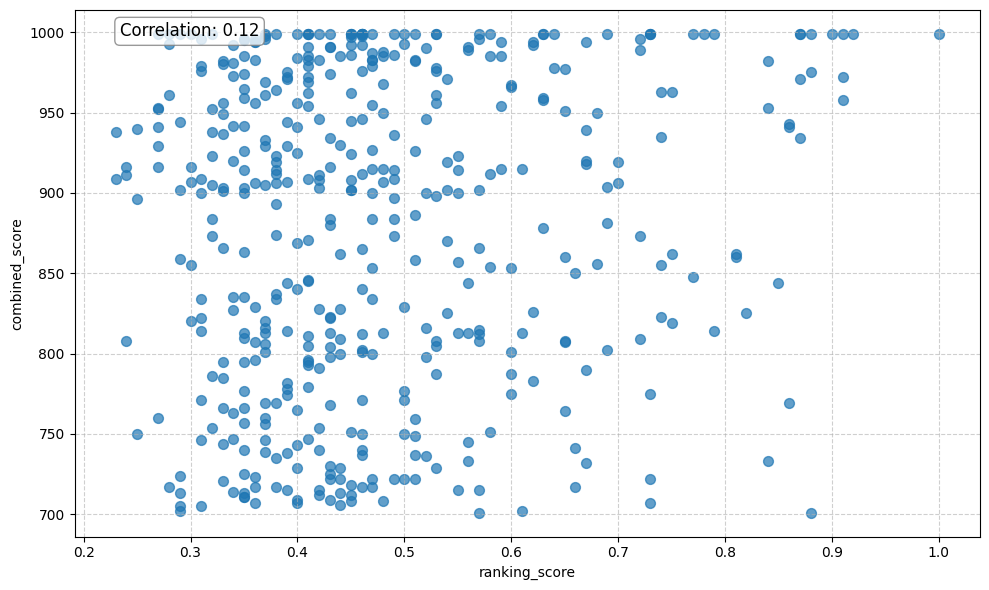

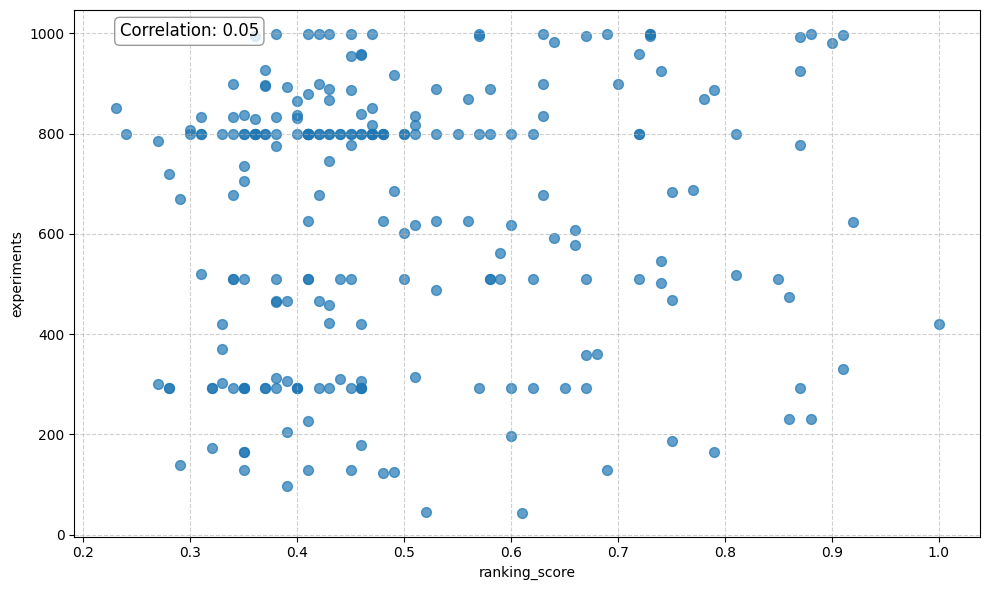

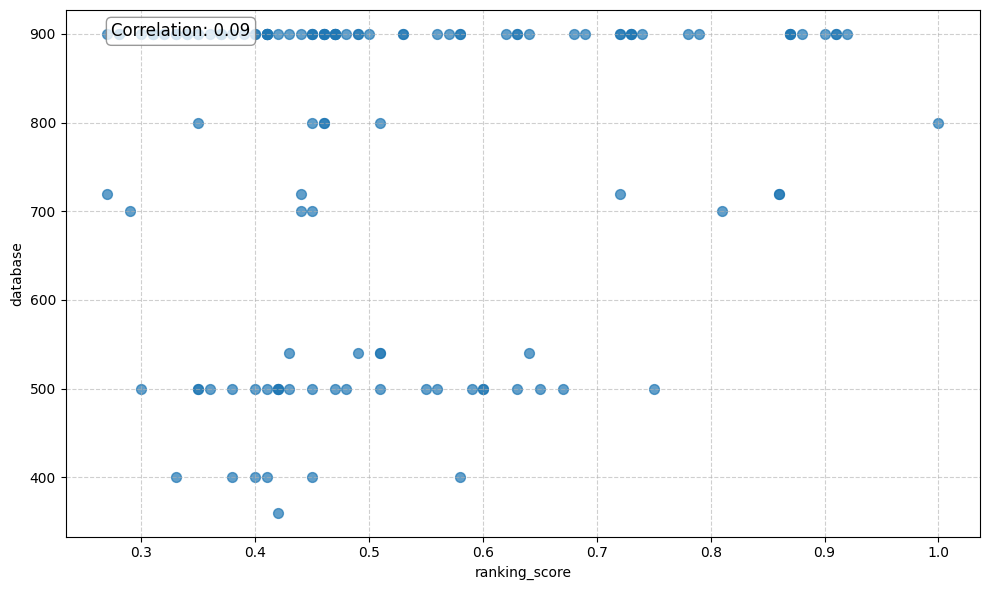

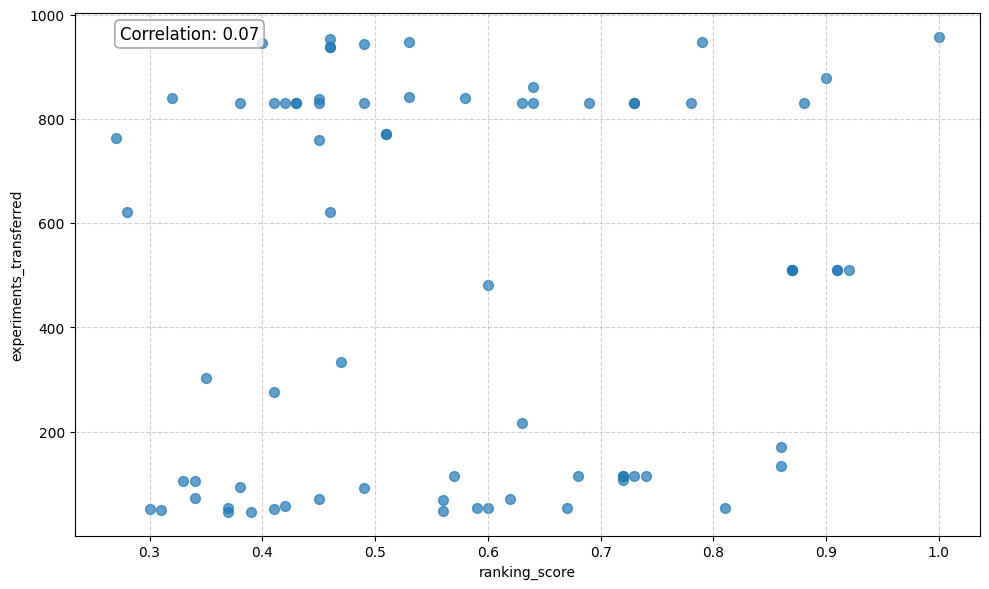

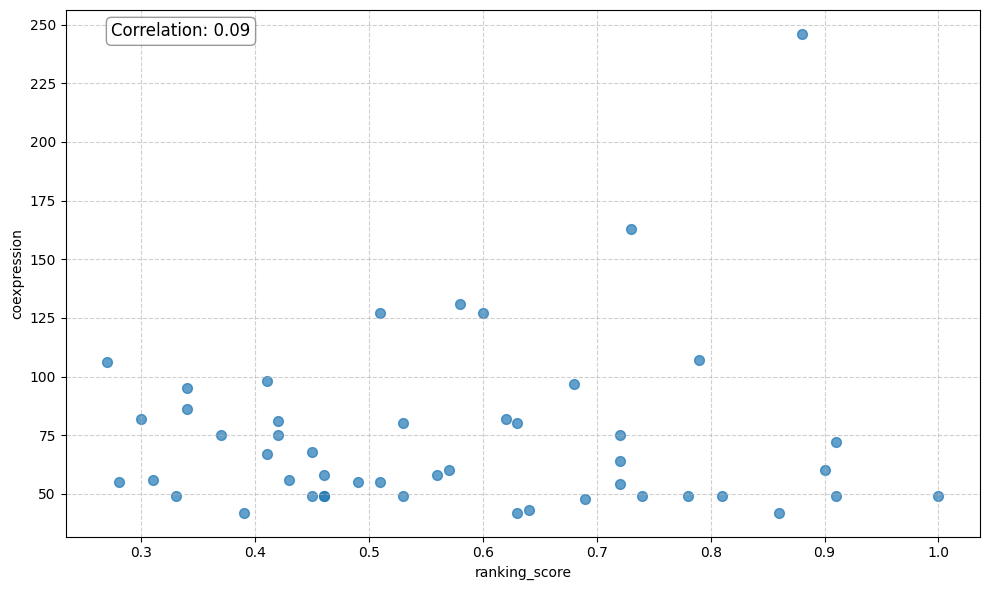

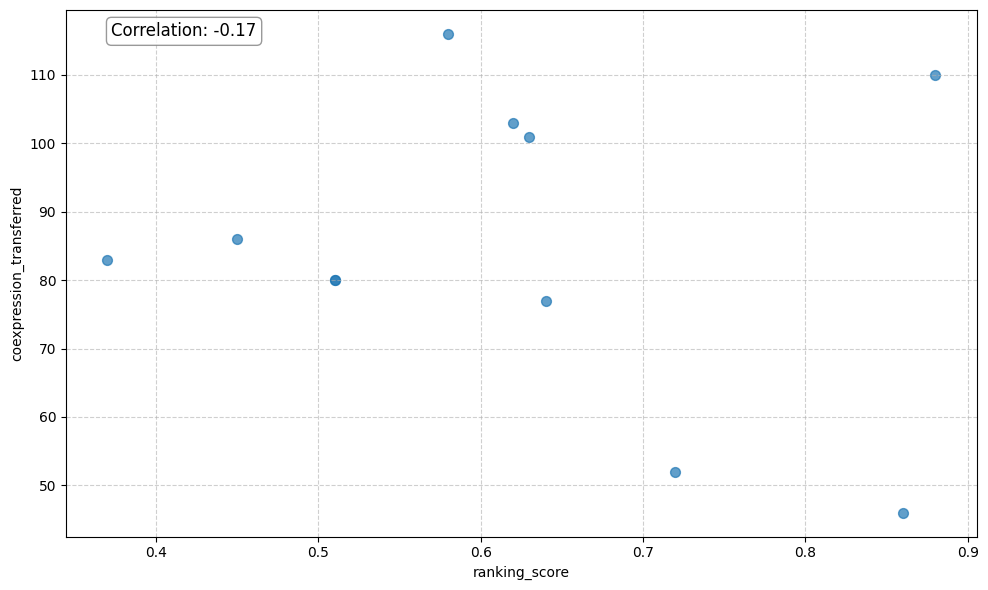

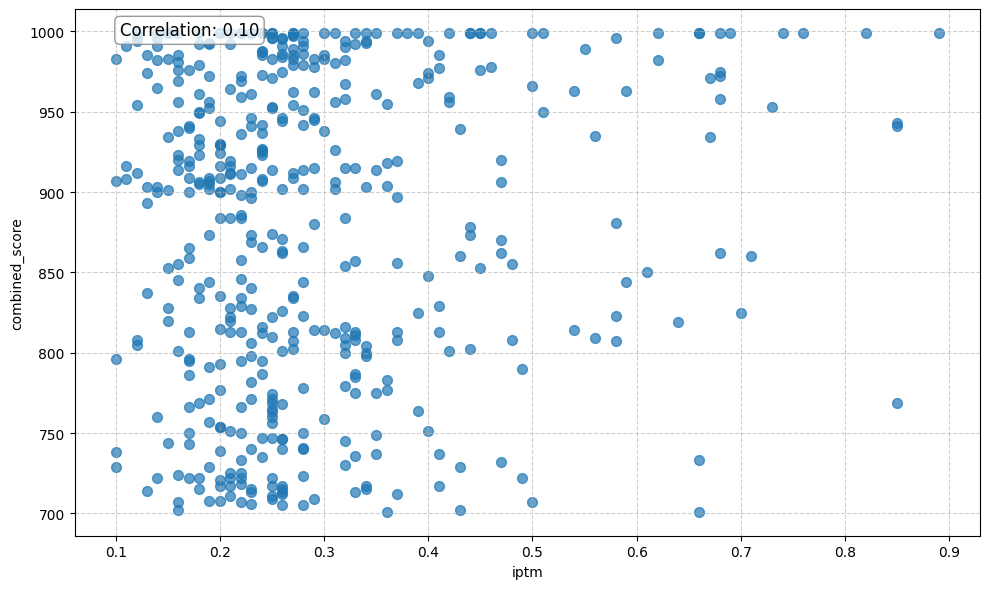

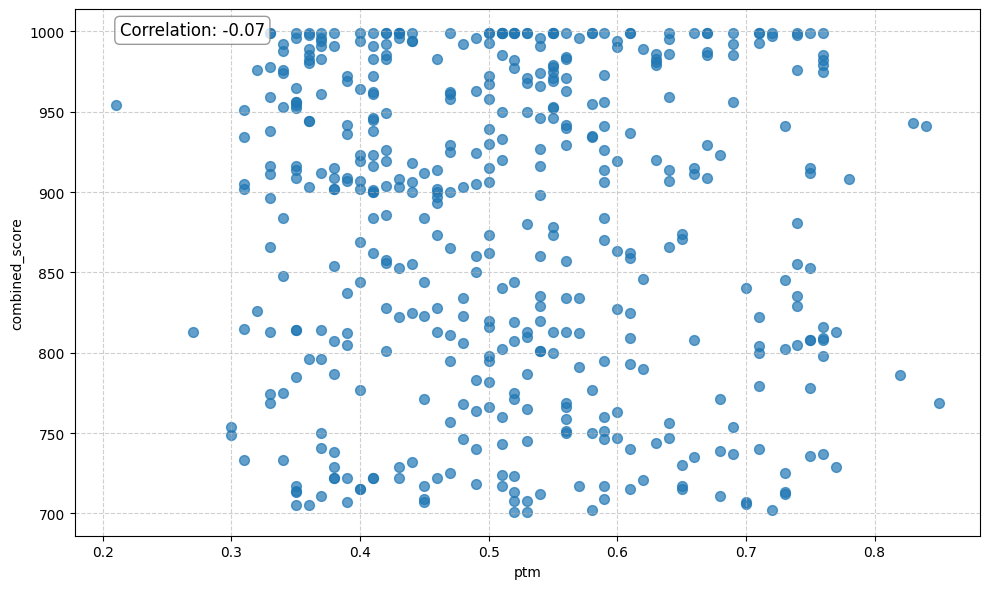

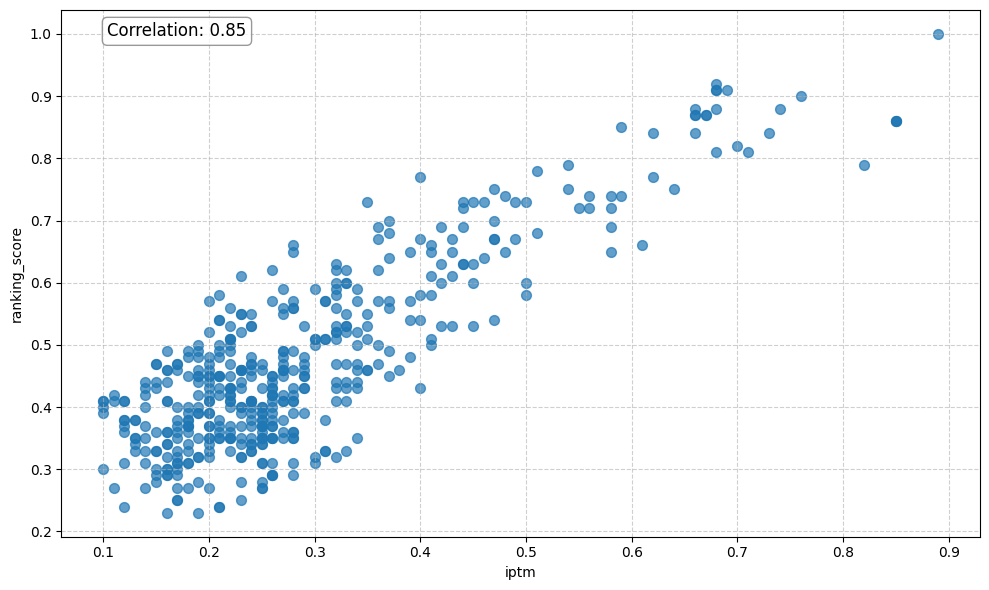

/home/markus/MPI_local/env_BA/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/markus/MPI_local/env_BA/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


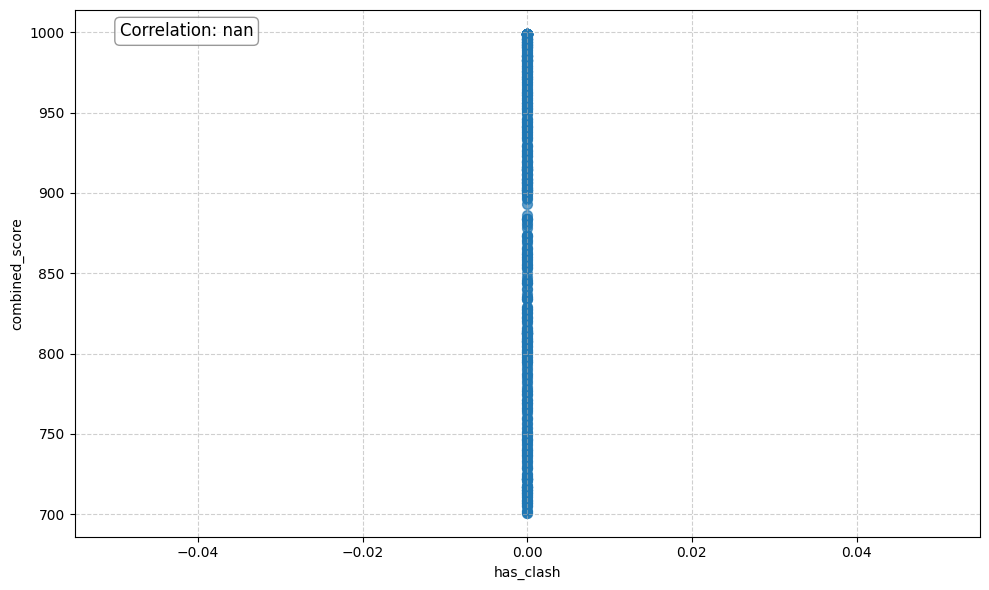

In [ ]:
def remove_0(df, cols):
    df[cols] = df[df[cols] > 0][cols]
    return df.dropna()

def scatter_corr(c1, c2, df):
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df[c1], df[c2], 
                        alpha=0.7, s=50)

    # Add labels and title
    plt.xlabel(c1)
    plt.ylabel(c2)
    # plt.title('AlphaFold Ranking Score vs STRING Combined Score for Protein Pairs')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Calculate and display correlation
    corr = df[c1].corr(df[c2])
    plt.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.tight_layout()
    plt.show()
    
scatter_corr('ranking_score', 'combined_score', merged_df)
scatter_corr('ranking_score', 'experiments', remove_0(merged_df, ['experiments']))
scatter_corr('ranking_score', 'database', remove_0(merged_df, ['database']))
scatter_corr('ranking_score', 'experiments_transferred', remove_0(merged_df, ['experiments_transferred']))
scatter_corr('ranking_score', 'coexpression', remove_0(merged_df, ['coexpression']))
scatter_corr('ranking_score', 'coexpression_transferred', remove_0(merged_df, ['coexpression_transferred']))
scatter_corr('iptm', 'combined_score', merged_df)
scatter_corr('ptm', 'combined_score', merged_df)
scatter_corr('iptm', 'ranking_score', merged_df)
scatter_corr('has_clash', 'combined_score', merged_df)

# High Confidence Protein Pairs

In [58]:
# Filter for protein pairs with combined_score > 900 and ranking_score > 0.5
high_confidence_pairs = merged_df[
    (merged_df['combined_score'] > 900) & 
    (merged_df['ranking_score'] > 0.5)
].copy()

# Sort by ranking_score in descending order
high_confidence_pairs = high_confidence_pairs.sort_values('ranking_score', ascending=False)

# Extract relevant columns for display
display_cols = ['job_name', 'p1_Uniprot', 'p2_Uniprot', 'ranking_score', 'combined_score', 'iptm', 'ptm']
high_confidence_display = high_confidence_pairs[display_cols]

# Print the results
print(f"Found {len(high_confidence_pairs)} high confidence protein pairs (combined_score > 900, ranking_score > 0.5)\n")
display(high_confidence_display)

# Additional insights
avg_iptm = high_confidence_pairs['iptm'].mean()
avg_ptm = high_confidence_pairs['ptm'].mean()
avg_combined = high_confidence_pairs['combined_score'].mean()
print(f"\nAverage metrics for high confidence pairs:")
print(f"Average iPTM: {avg_iptm:.2f}")
print(f"Average PTM: {avg_ptm:.2f}")
print(f"Average STRING combined score: {avg_combined:.2f}")

Found 78 high confidence protein pairs (combined_score > 900, ranking_score > 0.5)



,job_name,p1_Uniprot,p2_Uniprot,ranking_score,combined_score,iptm,ptm
38,q92600_1-299_o95628_1-575,O95628,Q92600,1.00,999,0.89,0.43
5,p35222_1-781_q9hcs4_1-588,Q9HCS4,P35222,0.92,999,0.68,0.50
91,p35222_1-781_q9nqb0_1-619,Q9NQB0,P35222,0.91,999,0.69,0.50
190,p14923_1-745_q9nqb0_1-619,P14923,Q9NQB0,0.91,972,0.68,0.50
81,p14923_1-745_q9hcs4_1-588,Q9HCS4,P14923,0.91,958,0.68,0.50
...,...,...,...,...,...,...,...
0,q6p1x5_1-1199_q9y6j9_1-622,Q9Y6J9,Q6P1X5,0.52,990,0.32,0.60
41,p42858_1-3142_p16220_1-327,P42858,P16220,0.51,982,0.32,0.76
57,q92797_1-1274_p33240_1-577,Q92797,P33240,0.51,999,0.31,0.37
167,q92797_1-1274_q9h0l4_1-616,Q92797,Q9H0L4,0.51,983,0.30,0.37



Average metrics for high confidence pairs:
Average iPTM: 0.45
Average PTM: 0.50
Average STRING combined score: 968.08
